# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import sys
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient
import time
import DcOrientRandomSimple
import DcSimple
import StaticSimple
import BigBucketSimple
import SmallBucketSimple
import StaticRandom

# Data Generation

In [2]:
G = misc.createRandomGraph(size=200, density=0.5, variation=0.4, maxDegree=None)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 222
Edges: 16230
Density: 0.6616118380824263
Max Degree: 162
Average Degree: 146.21621621621622
Static Coloring uses 52 colors at the end


5.350133917701487

In [3]:
updates = misc.extractUpdates(G, 'random')

In [44]:
updates = misc.extractStream(G, 10000, 0.5, 'random')

In [6]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

In [45]:
Ge = G.copy()

# Graph Saving and Loading

In [2]:
# Always define a name
name = 'graphRandom'

In [16]:
# Create graph data
nodes = list(Ge.nodes())
edges = list(Ge.edges())
updateEdges = list(update[0] for update in updates)
updateTypes = list(update[1] for update in updates)

ge = Ge.copy()
oldColoring = nx.coloring.greedy_color(ge)
newColoring = dict({})
staticColors = []
staticRecolors = []
for update in updates:
    if update[1]:
        ge.add_edge(update[0][0], update[0][1])
    else:
        ge.remove_edge(update[0][0], update[0][1])
    newColoring = nx.coloring.greedy_color(ge)
    staticColors.append(misc.numberOfColors(newColoring))
    staticRecolors.append(misc.numberOfRecolors(oldColoring, newColoring))
    oldColoring = newColoring

gd = misc.GraphData(name, nodes, edges, updateEdges, updateTypes, staticColors, staticRecolors)
totStaticColors = gd.colorSum
totStaticRecolors = gd.recolorSum

TypeError: 'list' object is not callable

In [9]:
# Save graph data
misc.saveGraphData(gd)

In [3]:
# Load graph data
gd = misc.loadGraphData(name)

Ge = gd.G.copy()

updates = gd.updates
staticColors = gd.staticColors
staticRecolors = gd.staticRecolors
totStaticColors = gd.colorSum
totStaticRecolors = gd.recolorSum

# Get final state of graph in local memory as well
G = gd.G.copy()
for update in updates:
    if update[1]:
        G.add_edge(update[0][0], update[0][1])
    else:
        G.remove_edge(update[0][0], update[0][1])

# Algorithm Preparation

In [7]:
# Only run once
experiments = []

In [6]:
class Exp:
    def __init__(self, G, experimentList, name):
        self.G = G
        self.experimentList = experimentList
        self.name = name

In [8]:
experimentList = []

experimentList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
# experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])

d = 5
experimentList.append([SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10])

d = 5
experimentList.append([BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10])

l = 10
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

l = 100
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

experimentList.append([DcOrient.DcOrientAlgo(Ge), 'DC-Orient'])

l = 10
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l), 'Static-Simple algorithm (l = ' +str(l)+ ')'])

l = 100
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l), 'Static-Simple algorithm (l = ' +str(l)+ ')'])

p = 0.8
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Simple (p = '+ str(p) + ')'])

p = 0.998
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Simple (p = '+ str(p) + ')'])

In [12]:
experimentList = []
p = 0.0
experimentList.append([DcOrientRandomSimple.DcOrientRandomSimpleAlgo(Ge, p), 'DC-Orient without optimizations'])
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Orient with optimizations'])

In [9]:
experiments.append(Exp(G, experimentList, name))

In [10]:
for exp in experiments:
    print(exp.name)

200Random


# Experimenting

In [11]:
def runExperiments(experiments, type='average'):

    validTypes = ['end', 'average', 'ratio']
    if type not in validTypes:
        print("Experiment type not valid, expected one of: " + str(validTypes))
        return


    for exp in experiments:
        
        G = exp.G
        experimentList = exp.experimentList
        name = exp.name

        # Load graph data
        gd = misc.loadGraphData(name)

        updates = gd.updates
        staticColors = gd.staticColors
        staticRecolors = gd.staticRecolors
        totStaticColors = gd.colorSum
        totStaticRecolors = gd.recolorSum

        # CSV Writer
        f = open('experiments/'+ str(name) + '.csv', 'w', newline='')
        writer = csv.writer(f)

        print('Graph used in the experiment:')
        misc.graphInfo(G)

        if (type == 'end'):
            C = staticColors[-1]
        elif (type == 'average'):
            C = round(float(totStaticColors)/len(updates), 2)
        elif (type == 'ratio'):
            C = 1
        row = [str(G.number_of_nodes()) + ' Nodes; ' + str(G.number_of_edges()) + ' Edges; C = ' + str(C),'Average nr. of Recolors', 'Average nr. of Colors', 'Time Taken (s)']
        writer.writerow(row)

        for experiment in experimentList:

            row = [str(experiment[1])]

            if len(experiment) == 3:
                random.seed(experiment[2])
            else:
                random.seed()

            print("")
            print("------------------------------------------------------------------")
            print(str(experiment[1]) + ":")
            iterator = misc.UpdateIterator(experiment[0], updates)

            recolors = 0
            colors = 0
            
            timer = time.perf_counter()

            while True:
                if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
                    raise ValueError('The coloring produced is incorrect')
                c1 = iterator.algo.getColoring()
                if iterator.runUpdate(1):
                    c2 = iterator.algo.getColoring()
                    recolors += misc.numberOfRecolors(c1, c2)
                    colors += misc.numberOfColors(c2)
                else:
                    #print("all updates finished")
                    break

            timer = time.perf_counter() - timer

            print("")

            if (type == 'end'):
                # End values
                print('Results measured at the end')
                avgRecolors = float(recolors)/len(updates)
                print("Average number of recolors per update: " + str(avgRecolors))
                row.append(str(round(avgRecolors, 2)))
                finalColors = misc.numberOfColors(iterator.algo.getColoring())
                print("Final number of colors used: " + str(finalColors))
                row.append(str(finalColors))

            elif (type == 'average'):
                # Average values
                print("Resuts averaged over the entire update sequence")
                avgRecolors = float(recolors)/len(updates)
                print("Average number of recolors per update: " + str(avgRecolors))
                row.append(str(round(avgRecolors, 2)))
                avgColors = float(colors/len(updates))
                print("Average number of colors used: " + str(avgColors))
                row.append(str(round(avgColors, 2)))

            elif (type == 'ratio'):
                # Ratios
                print("Results given as a ratio")
                recolorRatio = float(recolors)/totStaticRecolors
                print("Ratio of recolors: " + str(recolorRatio))
                row.append(str(round(recolorRatio, 4)))
                colorRatio = float(colors)/totStaticColors
                print("Ratio of colors used: " + str(colorRatio))
                row.append(str(round(colorRatio, 4)))

            print("Time taken : " + str(timer) + " seconds")
            row.append(str(round(timer, 3)))
            # print("Average elementary operations : " + str(iterator.avgElemCounter))
            print("------------------------------------------------------------------")
            writer.writerow(row)

        print("End of experiment list reached")
        f.close()


In [12]:
runExperiments(experiments, 'ratio')

Graph used in the experiment:
Nodes: 244
Edges: 12542
Density: 0.42305876003508064
Max Degree: 123
Average Degree: 102.80327868852459
Static Coloring uses 34 colors at the end

------------------------------------------------------------------
Random Warm-Up:

Results given as a ratio
Ratio of recolors: 0.00244148244473342
Ratio of colors used: 2.5546975325874546
Time taken : 30.6557442 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 5):

Results given as a ratio
Ratio of recolors: 0.14570546163849155
Ratio of colors used: 2.5756436961796982
Time taken : 34.72227620000001 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Big-Bucket algorithm (d = 5):

Results given as a ratio
Ratio of recolors: 0.20788686605981793
Ratio of colors used: 1.8033371271501277
Time taken : 35.073

In [51]:
nx.info(experiments[0].experimentList[0][0].G)

'Graph with 215 nodes and 12933 edges'

In [52]:
misc.numberOfColors(nx.coloring.greedy_color(experiments[0].experimentList[0][0].G))

39

# Graph Generation Experiments

In [4]:
e = [['SmallBucket', 1, 30],
    ['BigBucket', 1, 30],
    ['StaticDynamic', 1, 200],
    ['StaticSimple', 1, 200],
    ['DcSimple', 0.4, 1],
    ['StaticRandom', 0.4, 1]]

iterations = 3

In [29]:
e = [['BigBucket', 1, 30],
    ['BigBucketSimple', 0, 1, 2],
    ['BigBucketSimple', 0, 1, 5],
    ['BigBucketSimple', 0, 1, 10],
    ['BigBucketSimple', 0, 1, 20],
    ['BigBucketSimple', 0, 1, 30]]

iterations = 3

In [5]:
coordinateLists = []
experimentListList = []

# Add a single iteration for the random warm ups
experimentList = []
tempList = []
for j in range(0, iterations):
    tempList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
experimentList.append(tempList)
experimentListList.append(experimentList)

# experimentList = []
# experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])
# experimentListList.append(experimentList)

for exp in e:
    # Add different algorithms one by one by changing parameters
    experimentList = []
    algo = exp[0]
    min = exp[1]
    max = exp[2]
    r = 100             # Number of experiments per algorithm
    current = min
    lastCurrent = -100
    for i in range(0, r):
        if algo == 'SmallBucket':
            d = int(current)
            if d != int(lastCurrent):
                experimentList.append([[SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10]])
        elif algo == 'BigBucket':
            d = int(current)
            if d != int(lastCurrent):
                experimentList.append([[BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10]])
        elif algo == 'BigBucketSimple':
            d = exp[3] #temporary
            p = current
            experimentList.append([[BigBucketSimple.BigBucketSimpleAlgo(d, p, Ge), 'Big-Bucket Simple algorithm (p = '+str(p)+')']])
        elif algo == 'SmallBucketSimple':
            d = 10
            p = current
            experimentList.append([[SmallBucketSimple.SmallBucketSimpleAlgo(d, p, Ge), 'Small-Bucket Simple algorithm (p = '+str(p)+')']])
        elif algo == 'StaticDynamic':
            l = int(current)
            if l != int(lastCurrent):
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])
                experimentList.append(tempList)
        elif algo == 'StaticSimple':
            l = int(current)
            if l != int(lastCurrent):
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticSimple.StaticSimpleAlgo(Ge, l=l), 'Static-Simple (l = '+str(l)+')'])
                experimentList.append(tempList)
        elif algo == 'DcSimple':
            p = current
            tempList = []
            for j in range(0, iterations):
                tempList.append([DcSimple.DcSimpleAlgo(Ge, p=p), 'DC-Simple (p = '+str(p)+')'])
            experimentList.append(tempList)
        elif algo == 'StaticRandom':
            p = current
            tempList = []
            for j in range(0, iterations):
                tempList.append([StaticRandom.StaticRandomAlgo(Ge, p=p), 'Static Random (p = '+str(p)+')'])
            experimentList.append(tempList)

        lastCurrent = current
        current = current + ((max-min)/100)

    experimentListList.append(experimentList)

# Append a single iteration of DC-Orient
experimentList = []
experimentList.append([[DcOrient.DcOrientAlgo(Ge), 'DC-Orient', 10]])
experimentListList.append(experimentList)

In [6]:
# Print first experiment for each added algorithm
for experiments in experimentListList:
    print(experiments[0][0][1])

Random Warm-Up
Small-Bucket algorithm (d = 1)
Big-Bucket algorithm (d = 1)
Static-Dynamic algorithm (l = 1)
Static-Simple (l = 1)
DC-Simple (p = 0.4)
Static Random (p = 0.4)
DC-Orient


In [7]:
def runGraphExperiments(experimentListList, type='average'):

    validTypes = ['end', 'average', 'ratio']
    if type not in validTypes:
        print("Experiment type not valid, expected one of: " + str(validTypes))
        return

    # Iterate over each algorithm
    for currentExperimentList in experimentListList:
        loadingBar = False

        print('Graph used in the experiment:')
        misc.graphInfo(G)

        coords = []

        # Iterate over each parameter set for an algorithm
        for experiments in currentExperimentList:

            iters = len(experiments)
            totRecolors = 0
            totColors = 0
            totTime = 0
            i = 0

            # Iterate over each identical iteration of the algorithm, to average results out
            for experiment in experiments:

                recolors = 0
                colors = 0

                if len(experiment) == 3:
                    random.seed(experiment[2])
                else:
                    random.seed()

                print("")
                print("------------------------------------------------------------------")
                print(str(experiment[1]) + ":")
                iterator = misc.UpdateIterator(experiment[0], updates)

                
                i += 1
                print("Iteration " + str(i))
                timer = time.perf_counter()
                totalUpdates = len(updates)
                done = 0
                barLength = 64

                if loadingBar:
                    #line to be overwritten
                    print("")

                while True:
                    
                    if loadingBar:
                        #overwrite previously printed line
                        percentageDone = int(done/totalUpdates*barLength)
                        b = ("[" + percentageDone * "+" + (barLength - percentageDone) * "-" + "]")
                        sys.stdout.write('\r'+b)
                        sys.stdout.flush()

                    if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
                        raise ValueError('The coloring produced is incorrect')
                    c1 = iterator.algo.getColoring()
                    if iterator.runUpdate(1):
                        c2 = iterator.algo.getColoring()
                        recolors += misc.numberOfRecolors(c1, c2)
                        colors += misc.numberOfColors(c2)
                        done += 1
                    else:
                        #print("all updates finished")
                        break

                timer = time.perf_counter() - timer
                totTime += timer

                if loadingBar:
                    #overwrite previously printed line
                    b = ("")
                    sys.stdout.write('\r'+b)
                    sys.stdout.flush()

                avgRecolors = float(recolors)/len(updates)
                avgColors = float(colors)/len(updates)


                if (type == 'ratio'):
                    totRecolors += float(recolors)/totStaticRecolors
                    b = "Ratio of recolors: " + str(float(recolors)/totStaticRecolors)
                else:
                    totRecolors += avgRecolors
                    b = "Average number of recolors per update: " + str(avgRecolors)
                b = b + (barLength + 2 - len(b)) * " "
                print(b)

                if (type == 'end'):
                    totColors += misc.numberOfColors(iterator.algo.getColoring())
                    print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))
                elif (type == 'average'):
                    totColors += avgColors
                    print("Average number of colors used: " + str(avgColors))
                elif (type == 'ratio'):
                    totColors += float(colors)/totStaticColors
                    print("Ratio of number of colors used: " + str(float(colors)/totStaticColors))


                print("Time taken : " + str(timer) + " seconds")
                #print("Average elementary operations : " + str(iterator.avgElemCounter))
                print("------------------------------------------------------------------")
            coords.append([totRecolors/iters, totColors/iters, totTime/iters])

        print("End of experiment list reached")
        coordinateLists.append(coords)


In [8]:
runGraphExperiments(experimentListList, 'ratio')

Graph used in the experiment:
Nodes: 205
Edges: 12594
Density: 0.6022955523672884
Max Degree: 138
Average Degree: 122.86829268292684
Static Coloring uses 42 colors at the end

------------------------------------------------------------------
Random Warm-Up:
Iteration 1
Ratio of recolors: 0.00229150518381121                            
Ratio of number of colors used: 2.5359255701066896
Time taken : 32.81981400000001 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up:
Iteration 2
Ratio of recolors: 0.0022847355968575577                          
Ratio of number of colors used: 2.498251937676522
Time taken : 31.212693299999998 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up:
Iteration 3
Ratio of recolors: 0.0022881203903343836                          
Ratio of number of col

In [9]:
coordinateLists

[[[0.002288120390334384, 2.516908770890669, 31.240155333333337]],
 [[0.015820524710684777, 8.047259081617174, 36.66957430000002],
  [0.11273054674569032, 2.427997168427972, 33.17933360000001],
  [0.14033353754920644, 2.0342208481713966, 32.33779709999999],
  [0.15398779443472257, 1.985867421752541, 32.73367220000003],
  [0.16866764374371698, 1.8808644962763383, 32.72715770000002],
  [0.16331290046337824, 2.2418790947637586, 34.471652000000006],
  [0.16308273450695407, 2.2910740470532147, 35.42472319999996],
  [0.19195163807080312, 1.8129103793006307, 32.99960330000005],
  [0.18850930310487105, 2.0309956009505994, 34.537025400000005],
  [0.18795081218119478, 2.1047284363510284, 34.953398100000015],
  [0.18793388821381063, 2.1083437470654944, 36.10735189999997],
  [0.18793388821381063, 2.1083437470654944, 35.493988700000045],
  [0.18793388821381063, 2.1083437470654944, 35.95471429999998],
  [0.18793388821381063, 2.1083437470654944, 33.360317099999975],
  [0.18793388821381063, 2.108343747

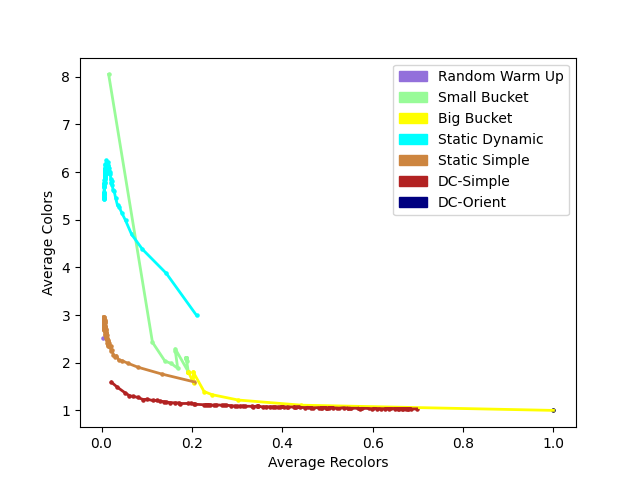

In [10]:
plt.close()

algoNames = ['Random Warm Up', 'Small Bucket', 'Big Bucket', 'Static Dynamic', 'Static Simple', 'DC-Simple', 'Static Random', 'DC-Orient']
colorDict = matplotlib.colors.CSS4_COLORS
colors = [colorDict.get('mediumpurple'), colorDict.get('palegreen'), colorDict.get('yellow'), colorDict.get('cyan'), colorDict.get('peru'), colorDict.get('firebrick'), colorDict.get('pink'), colorDict.get('navy')]
patches = []


j = 0
for list in coordinateLists:

    if not (j == 6):

        color = colors[j]
        patch = matplotlib.patches.Patch(color=color, label=algoNames[j])
        patches.append(patch)
        
        xcoords = [i[0] for i in list]
        ycoords = [i[1] for i in list]

        # Original line plot
        plt.plot(xcoords, ycoords, c=color, linewidth=2)

        # Points plot
        plt.scatter(xcoords, ycoords, c=color, s=5)

    j += 1

# Adjust labels depending on type of experiment
plt.xlabel("Average Recolors")
plt.ylabel("Average Colors")
plt.legend(handles=patches)
plt.show()

[(1, 2), (2, 3)]


(1 2)
(1 3)
(1 2)
(2 3)


[0, 1]

# Results

In [74]:
runExperiments(experiments)

Graph used in the experiment:
Nodes: 119
Edges: 4531
Density: 0.6453496652898447
Max Degree: 91
Average Degree: 76.15126050420169
Static Coloring uses 30 colors

------------------------------------------------------------------
Small-Bucket algorithm (d = 1):

Average number of recolors per update: 0.286470977709115
Total number of colors used at the end: 119
Time taken : 5.674505700000736 seconds
Average elementary operations : 1.1302140807768704
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 3):

Average number of recolors per update: 3.1505186493047894
Total number of colors used at the end: 56
Time taken : 4.820692299999791 seconds
Average elementary operations : 3.221584639152505
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 5):

Average number of rec

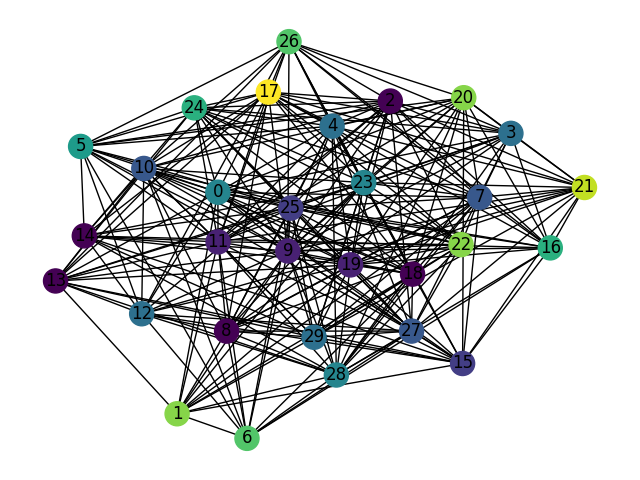

True
